In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import math
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
def rotate_image(img):
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = img
    edges = cv2.Canny(gray,50,150,apertureSize = 3)

    lines = cv2.HoughLines(edges,1,np.pi/180,200)
    angle = 0

    if lines is not None:
        for rho,theta in lines[0]:
            angle = math.degrees(theta)-90
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
    # print(angle)

    # Do skew correction only if the angle of rotation is greather than 3 degrees
    if abs(angle%90) > 3:
        if angle < 0:
            angle = -1* angle
        if angle > 45:
            angle = 90-angle
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        # cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
#         print("Image rotated by angle: {:.3f}".format(angle))
        return rotated
    else:
        return img

In [3]:
def square(img):
    """
    This function resize non square image to square one (height == width)
    :param img: input image as numpy array
    :return: numpy array
    """
    # image after making height equal to width
    squared_image = img

    # Get image height and width
    h = img.shape[0]
    w = img.shape[1]

    # In case height superior than width
    if h > w:
        diff = h-w
        if diff % 2 == 0:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = x1
        else:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = np.zeros(shape=(h, (diff//2)+1))
        squared_image = np.concatenate((x1, img, x2), axis=1)

    # In case height inferior than width
    if h < w:
        diff = w-h
        if diff % 2 == 0:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = x1
        else:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = np.zeros(shape=((diff//2)+1, w))
        squared_image = np.concatenate((x1, img, x2), axis=0)

    return squared_image

In [4]:
# Detect chars
filename = 'I00001.png' # 'I00003.png' # 'I00005.png'
img_file_path = os.path.join(os.path.abspath(os.getcwd()), 'data/unzipped_data/crop_h4/', filename)
annotation = '1B49951'

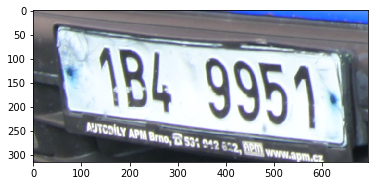

In [5]:
img = cv2.imread(img_file_path)
imshow(img)

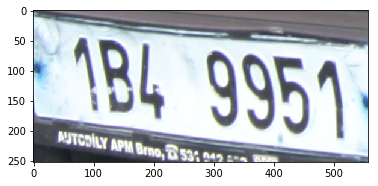

In [6]:
img = img[round(img.shape[0]*0.1):round(img.shape[0]*0.9), round(img.shape[1]*0.1):round(img.shape[1]*0.9)]
imshow(img)

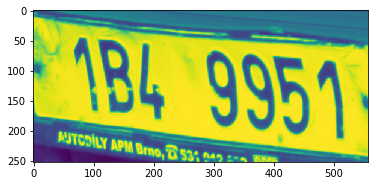

In [7]:
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(imgray)

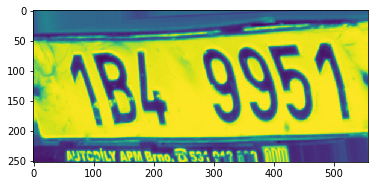

In [8]:
imgray = rotate_image(imgray)
imshow(imgray)

In [9]:
# from scipy.signal import convolve2d as conv2
# from skimage import color, data, restoration

# psf = np.ones((3, 3)) / 25
# # noise_img = conv2(imgray, psf, 'same')
# noise_img = imgray

# # Restore Image using Richardson-Lucy algorithm
# deconvolved_RL = restoration.richardson_lucy(noise_img, psf, iterations=30)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
# plt.gray()

# for a in (ax[0], ax[1]):
#        a.axis('off')

# ax[0].imshow(imgray)
# ax[0].set_title('Original Data')

# ax[1].imshow(deconvolved_RL, vmin=noise_img.min(), vmax=noise_img.max())
# ax[1].set_title('Restoration using\nRichardson-Lucy')


# fig.subplots_adjust(wspace=0.02, hspace=0.2,
#                     top=0.9, bottom=0.05, left=0, right=1)
# plt.show()

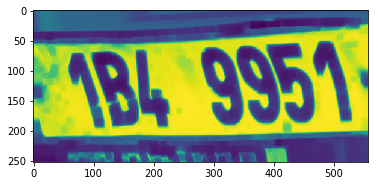

In [10]:
kernel = np.ones((8,8), np.uint8) 
eroded_img = cv2.erode(imgray, kernel, iterations=1) 
imshow(eroded_img)

In [11]:
imgray = eroded_img

In [12]:
# kernel = np.ones((2,2),np.uint8)

# dilation = cv2.dilate(imgray,kernel,iterations = 1)
# imgray = dilation
# imshow(dilation)

# closing = cv2.morphologyEx(imgray, cv2.MORPH_CLOSE, kernel)
# imgray = closing
# imshow(closing)

# imgray = cv2.morphologyEx(imgray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
# imshow(imgray)

In [13]:
height = img.shape[0]
width = img.shape[1]
area = height * width

scale1 = 0.001 # static value
scale2 = 0.1 # static value
area_condition1 = area * scale1
area_condition2 = area * scale2

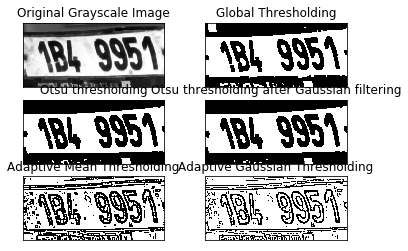

In [14]:
# Global Thresholding
ret1,th1 = cv2.threshold(imgray,127,255,cv2.THRESH_BINARY)

# Otsu's Thresholding
ret2,th2 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Adaptive Mean Thresholding
th4 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

# Adaptive Gaussian Thresholding
th5 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(imgray,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

titles = ['Original Grayscale Image', 'Global Thresholding', 'Otsu thresholding', 'Otsu thresholding after Gaussian filtering',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [imgray, th1, th2, th3, th4, th5]

for i in range(6):
    plt.subplot(3,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### The main difference between different type of contours is in the hierarchy that is returned (giving the relationship between one contour and the next).

- CV_RETR_EXTERNAL gives "outer" contours, so if you have (say) one contour enclosing another (like concentric circles), only the outermost is given.
- CV_RETR_LIST gives all the contours and doesn't even bother calculating the hierarchy -- good if you only want the contours and don't care whether one is nested inside another.
- CV_RETR_CCOMP gives contours and organises them into outer and inner contours. Every contour is either the outline of an object, or the outline of an object inside another object (i.e. hole). The hierarchy is adjusted accordingly. This can be useful if (say) you want to find all holes.
- CV_RETR_TREE calculates the full hierarchy of the contours. So you can say that object1 is nested 4 levels deep within object2 and object3 is also nested 4 levels deep.

In [15]:
contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy = cv2.findContours(th3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [16]:
# sort contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [17]:
final_contours = []
aspect_ratio_filtered_contours = []
aspect_ratio_filtered_contours_area = []
area_filtered_contours = []
area_filtered_contours_centroids = []

for cnt in contours:
    (x,y,w,h) = cv2.boundingRect(cnt)
    if (w * h > area_condition1 and w * h < area_condition2 and (w/h > 0.3 or h/w > 0.3)):
        aspect_ratio_filtered_contours.append(cnt)
        aspect_ratio_filtered_contours_area.append(w * h)
max_cnt_area = max(aspect_ratio_filtered_contours_area)

counter = 1
for cnt, cnt_area in zip(aspect_ratio_filtered_contours, aspect_ratio_filtered_contours_area):
    if cnt_area >= 0.3 * max_cnt_area:
        area_filtered_contours.append(cnt)
        cnt_moment = cv2.moments(cnt)
        area_filtered_contours_centroids.append((counter, int(cnt_moment['m10']/cnt_moment['m00']), int(cnt_moment['m01']/cnt_moment['m00'])))
        counter += 1

if len(area_filtered_contours) > 7:
    area_filtered_contours_centroids.sort(key = lambda x: x[2], reverse=True)
    print(area_filtered_contours_centroids)
    centroid_means = [sum(ele) / len(area_filtered_contours_centroids) for ele in zip(*area_filtered_contours_centroids)]
    print(centroid_means)
    centroid_mean_distance = list()
    for ele in area_filtered_contours_centroids:
        centroid_mean_distance.append((ele[0], ele[1], ele[2], abs(math.sqrt((ele[1] - centroid_means[1])**2 + (ele[2] - centroid_means[2])**2))))
    centroid_mean_distance.sort(key = lambda x: x[3], reverse=False)
    print(centroid_mean_distance)
    counter = 1
    for cnt, cnt_centroid_mean_dist in zip(area_filtered_contours, centroid_mean_distance):
        if counter <= 7:
            final_contours.append(cnt)
            counter += 1
        else:
            break
else:
    final_contours = area_filtered_contours
# final_contours = area_filtered_contours

In [18]:
cropped_chars = []
bounding_boxes = []
for cnt in final_contours:
    (x,y,w,h) = cv2.boundingRect(cnt)
    cv2.drawContours(img, [cnt], 0, (0, 255, 0), 3)
    cv2.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 2)
    c = th3[y:y+h,x:x+w]
    c = np.array(c)
    c = cv2.bitwise_not(c)
    c = square(c)
    c = cv2.resize(c,(28,28), interpolation = cv2.INTER_AREA)
    cropped_chars.append(c)
    bounding_boxes.append((x,y,w,h))

In [19]:
print(len(cropped_chars))
print(len(bounding_boxes))
print(len(final_contours))

7
7
7


In [20]:
bounding_boxes

[(97, 68, 80, 125),
 (279, 61, 71, 130),
 (338, 58, 73, 130),
 (388, 54, 81, 133),
 (465, 51, 65, 134),
 (170, 66, 57, 128),
 (59, 71, 60, 124)]

In [21]:
a = list(map(tuple, zip(cropped_chars, final_contours, bounding_boxes)))

In [22]:
sorted_cropped_chars, sorted_final_contours, sorted_bounding_boxes = zip(*sorted(a, key = lambda x: x[2][0], reverse=False))

In [23]:
# (sorted_cropped_chars, sorted_final_contours, sorted_bounding_boxes) = zip(*sorted(zip(cropped_chars, final_contours, bounding_boxes), key=lambda b:b[2][0], reverse=False))

In [24]:
sorted_bounding_boxes

((59, 71, 60, 124),
 (97, 68, 80, 125),
 (170, 66, 57, 128),
 (279, 61, 71, 130),
 (338, 58, 73, 130),
 (388, 54, 81, 133),
 (465, 51, 65, 134))

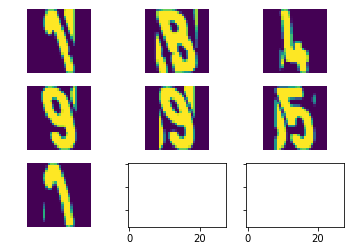

In [25]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True) 
for cropped_char, ax in zip(sorted_cropped_chars, axes.flat):
    ax.imshow(cropped_char)
    ax.axis('off')

In [26]:
for index, cnt in enumerate(sorted_final_contours):
    (x,y,w,h) = cv2.boundingRect(cnt)
    img = cv2.putText(img, str(annotation[index]).upper(), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (50,50,50), 2) # green - (36,255,12)

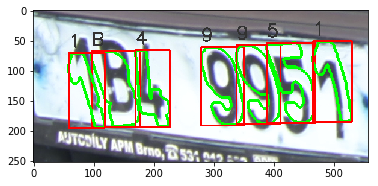

In [27]:
imshow(img)

In [28]:
from segment_chars import get_segmented_chars

filename = 'I00001.png'
img_file_path = os.path.join(os.path.abspath(os.getcwd()), 'data/unzipped_data/crop_h4/', filename)
annotation = '1B49951'
segmented_chars, segmented_img = get_segmented_chars(img_file_path, annotation)

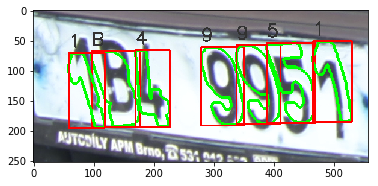

In [29]:
imshow(segmented_img)

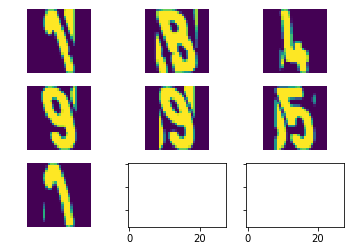

In [30]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True) 
for segmented_char, ax in zip(segmented_chars, axes.flat):
    ax.imshow(segmented_char)
    ax.axis('off')